## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))
  

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        confs.append(confidence)
        errs.append(errors)
       
    
    # Compute aggregate error metric
    errs = np.hstack(errs)
    
    confs = np.hstack(confs)
    print("after stacking")
    print(len(errs),len(confs))
   
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    gtArr = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)
 
    # Compute pulse rate estimates and estimation confidence.
    
    # Frequency Domain analysis
    fil_ppg = BandpassFilter(ppg)
   
    acc = np.sqrt(np.square(accx)+np.square(accy)+np.square(accz))
    fil_acc = BandpassFilter(acc)
   
    plt.plot(fil_ppg)
    plt.show()
    plt.title("PPG SpecGram")
    ppg_spec,ppg_freq,_,_ = plt.specgram(fil_ppg,Fs=125,NFFT=1000,noverlap=750)
    plt.show()
  
    plt.plot(fil_acc)
    plt.show()
    plt.title("ACC SpecGram")
    acc_spec,_,_,_ = plt.specgram(fil_acc,Fs=125,NFFT=1000,noverlap=750)
    plt.show()
  
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    #Iteration 1, prediction is the max signal value from the ppg spectrum
    
    # Get the frequency of peaks of ppg
    # get the peak frequency of acc
    # Remove peak frequecies of acc from ppg
    # Do max or mean of the freq
    predMaxPPGFreq = ppg_freq[np.argmax(ppg_spec,axis=0)]
    # Second max PPG Freq
    predSecMaxPPGFreq = ppg_freq[np.argsort(ppg_spec, axis=0)[-2]]
       
    predMaxAccFreq = ppg_freq[np.argmax(acc_spec,axis=0)]
    
    predFreq = [x if x != y else z for x,y,z in zip(predMaxPPGFreq,predMaxAccFreq,predSecMaxPPGFreq)]
    
    pred = np.array(predFreq)
            
    err = pred*60 - gtArr
    conf = np.max(ppg_spec,axis=0)/np.sum(ppg_spec,axis=0)
   
    
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(pred)
  
    ax2.plot(gtArr)
    plt.show()       

    ref=len(gtArr)
    
    
     
    return err[:ref],conf[:ref]
   

In [2]:
def BandpassFilter(signal, band_pass = (40/60, 200/60), fs = 125):
    """ Performs a bandpass filter on the signal. """
    
    b,a = scipy.signal.butter(5, band_pass, fs=fs, btype= 'bandpass')
    
    # Perform forward and backward digital butterworth filter
    return scipy.signal.filtfilt(b,a,signal)


In [3]:
def EvaluateOne():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    # Run the pulse rate algorithm on each trial in the dataset
    errors, confidence = RunPulseRateAlgorithm(data_fls[0], ref_fls[0])
    errs.append(errors)
    confs.append(confidence)
   
     
    # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    print(len(errs),len(confs))
    return AggregateErrorMetric(errs, confs)


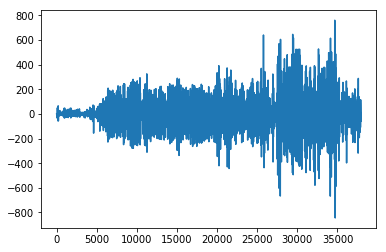

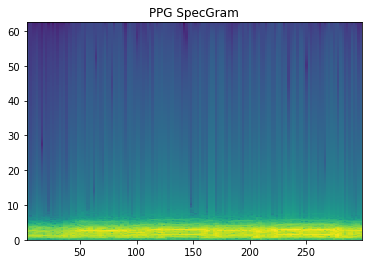

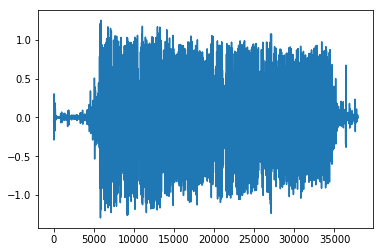

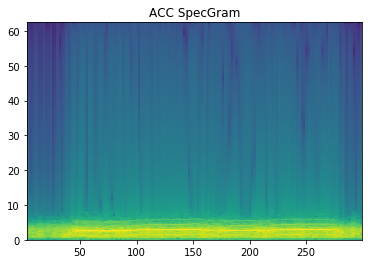

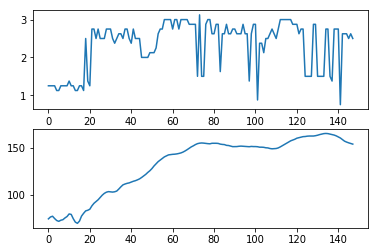

148 148


24.452359750708062

In [4]:
EvaluateOne()

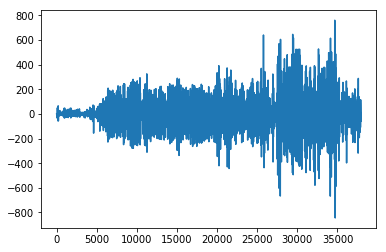

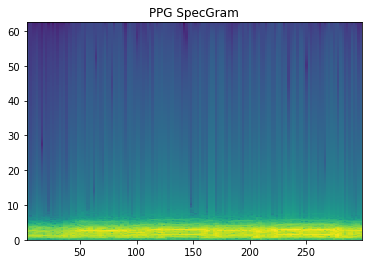

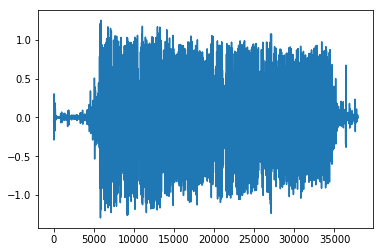

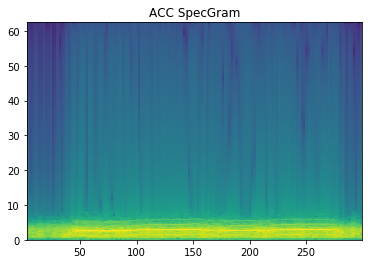

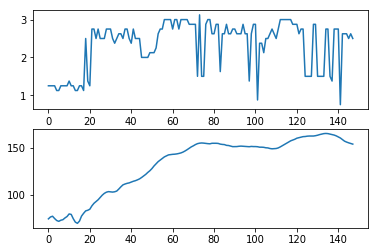

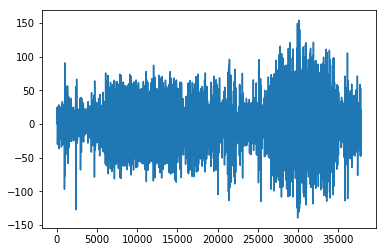

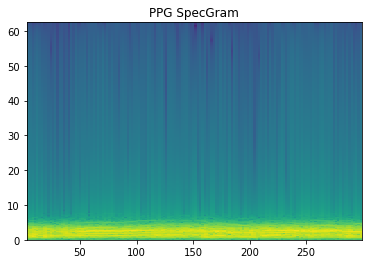

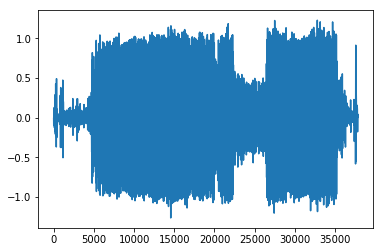

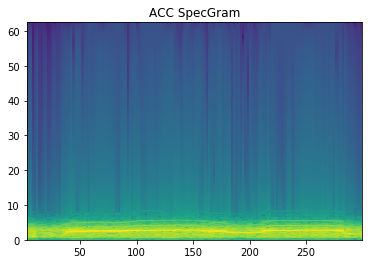

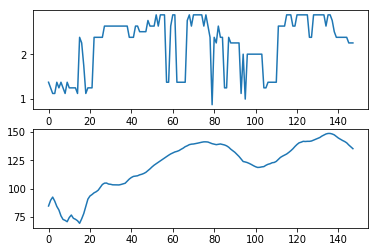

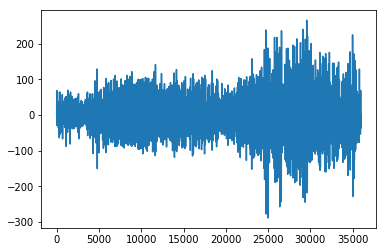

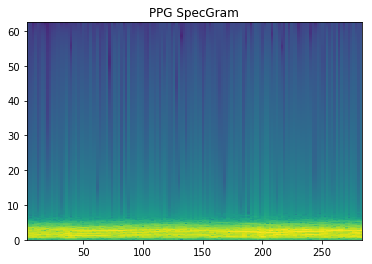

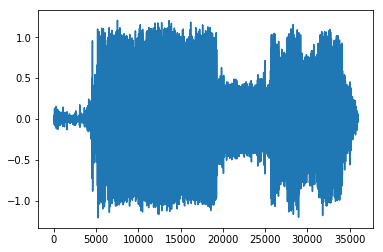

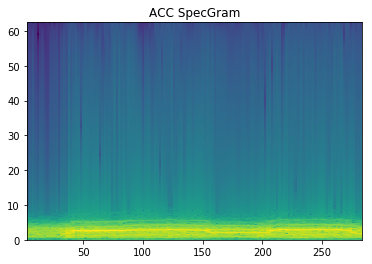

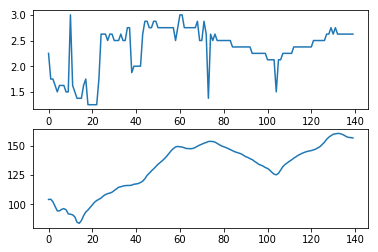

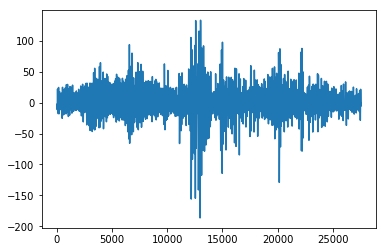

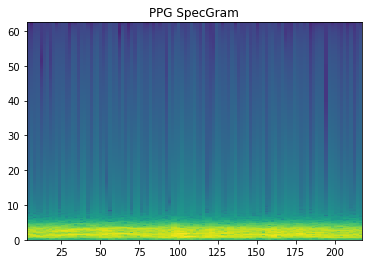

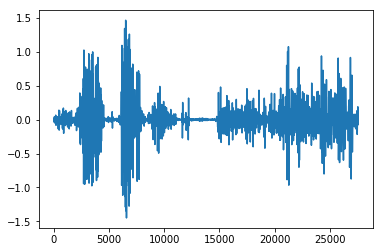

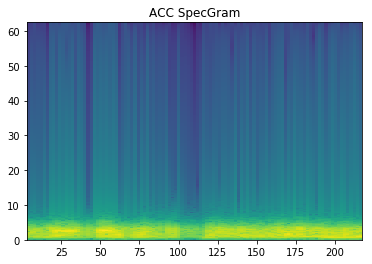

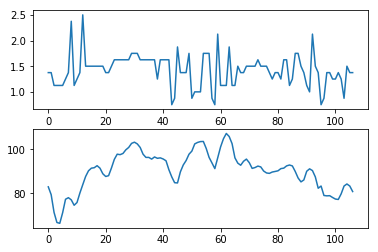

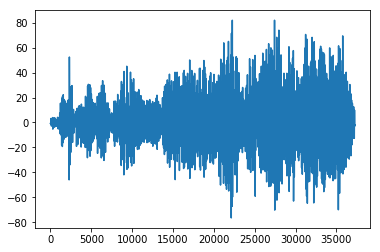

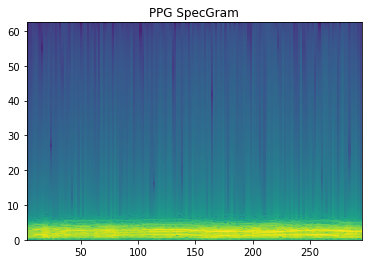

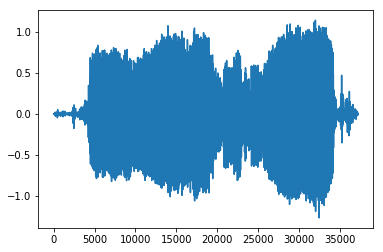

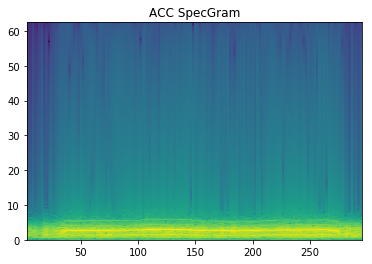

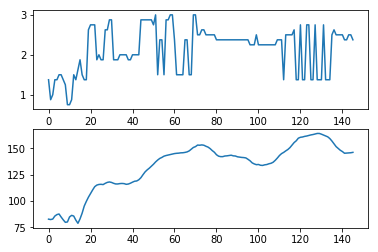

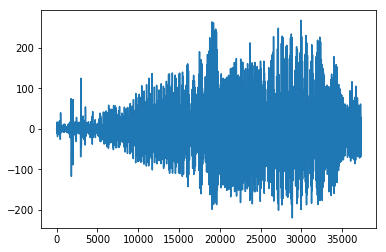

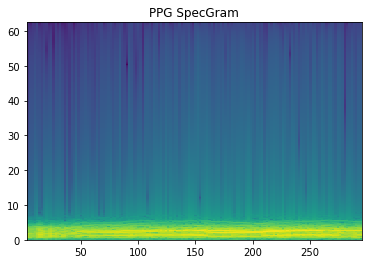

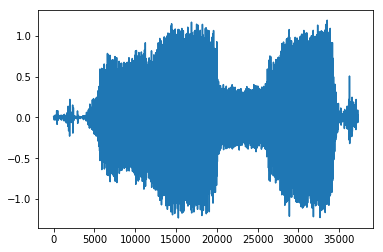

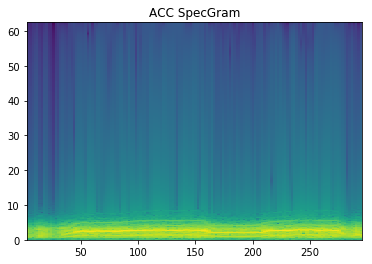

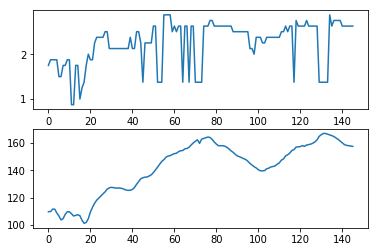

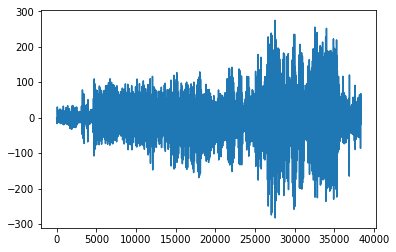

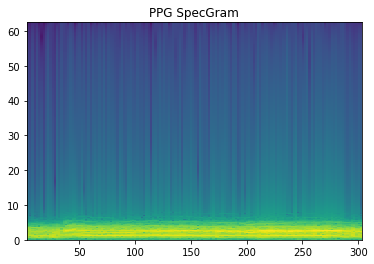

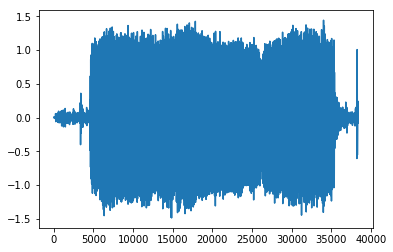

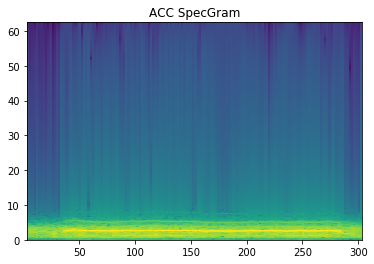

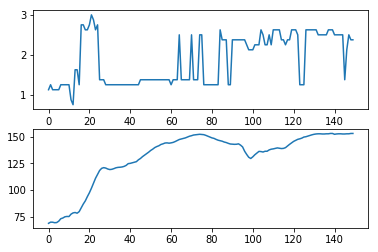

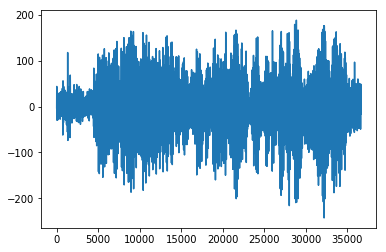

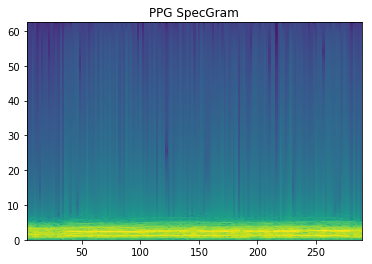

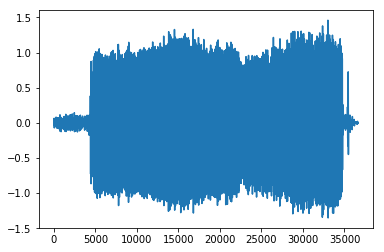

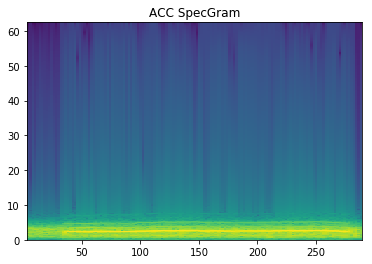

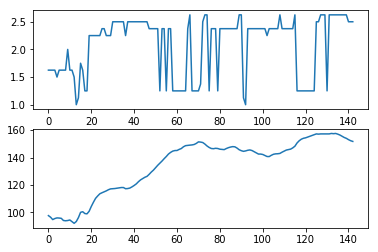

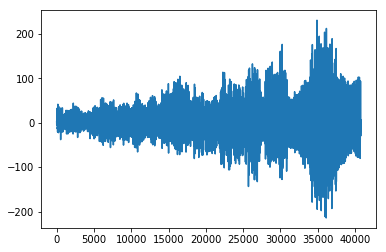

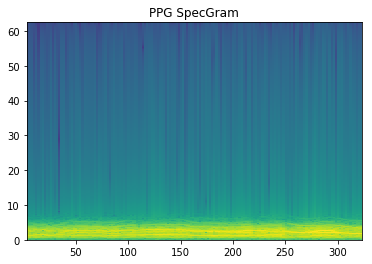

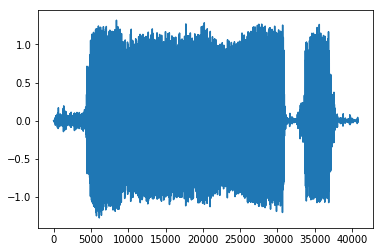

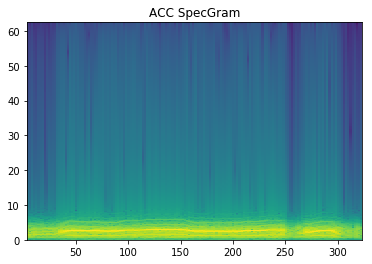

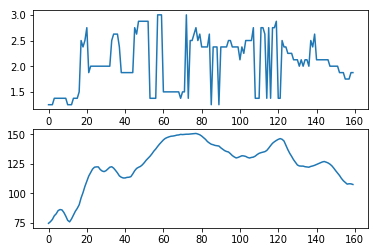

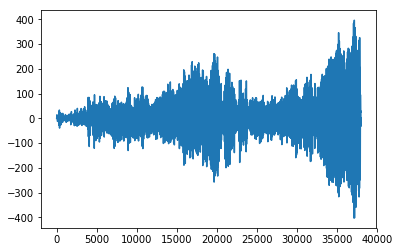

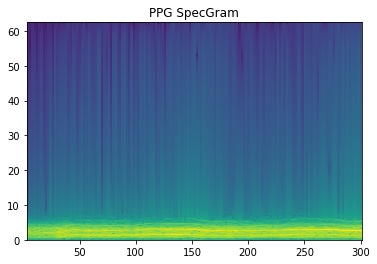

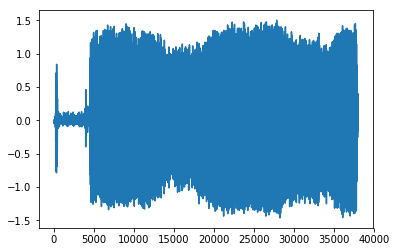

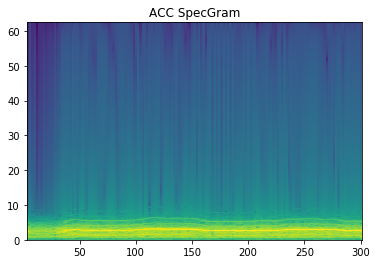

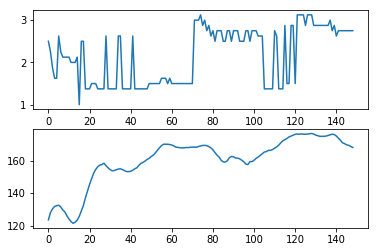

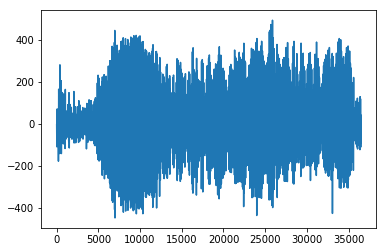

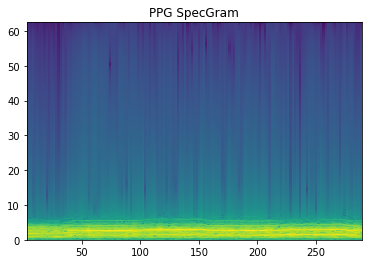

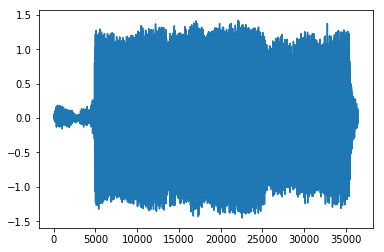

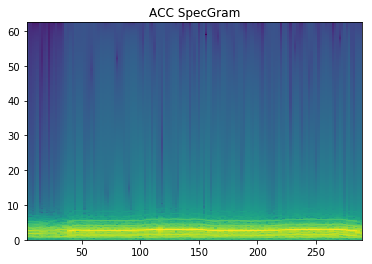

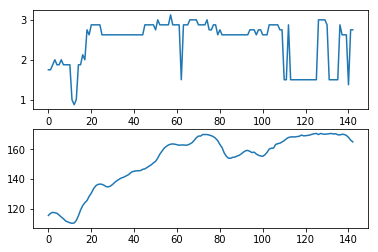

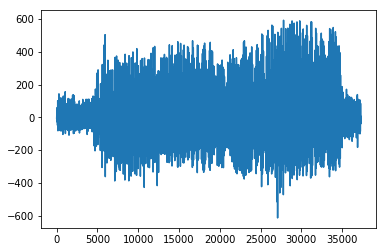

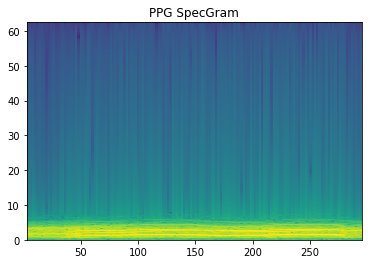

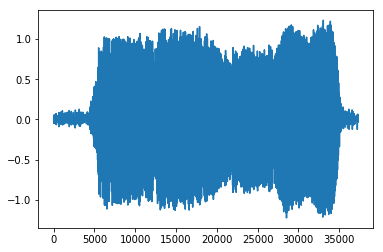

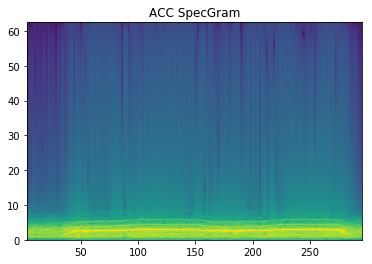

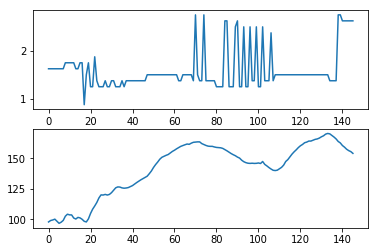

after stacking
1726 1726


24.574166218068562

In [5]:
Evaluate()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...
**Code Description**
EvaluateOne is a test code to do one file
The RunPulseRateAlgorithm is where all the code is present. It first filters both the signal so it contains only frequencies in the range 40/60 and 240/60 as specified in the problem description.
Then visualizing the specgram of both the ppg and accelerometer.
Then visualize prediction vs error.
**Data Description**
need to work here

**Algorithm Performance**
It meets the


-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 